<a href="https://colab.research.google.com/github/mehrshadhosseini28/NMA/blob/master/Mickey_Mouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 15]
rcParams['font.size'] =8
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
rcParams['figure.max_open_warning']=100

### Mean Velocity

In [ ]:
#@title Required data
ext_wheel = [[[[[] for j4 in range(2)] for j3 in range(2)] for j2 in range(2)] for j1 in range(39)]

counter = 0
for i0, data in enumerate(alldat): 
  response = data['response']
  contrast_r = data['contrast_right']
  contrast_l = data['contrast_left']
  correct_idx = np.logical_or(np.logical_and(response>0, contrast_l-contrast_r>0),
                              np.logical_and(response<0, contrast_l-contrast_r<0))
  wrong_idx = np.logical_or(np.logical_and(response>0, contrast_l-contrast_r<0),
                              np.logical_and(response<0, contrast_l-contrast_r>0))
  
  right_idx = response<0
  left_idx = response>0
  
  ext_025_idx = np.logical_and(contrast_r*contrast_l==0, contrast_r+contrast_l==0.25)
  ext_05_idx = np.logical_and(contrast_r*contrast_l==0, contrast_r+contrast_l==0.5)
  ext_01_idx = np.logical_and(contrast_r*contrast_l==0, contrast_r+contrast_l==1)

  ext_255_idx = np.logical_and(contrast_r*contrast_l==0.125, contrast_r+contrast_l==0.75)
  ext_251_idx = np.logical_and(contrast_r*contrast_l==0.25, contrast_r+contrast_l==1.25)
  
  for i1, r in enumerate([correct_idx, wrong_idx]):
    for i2, side in enumerate([right_idx, left_idx]):
      for i3, diff in enumerate([ext_025_idx, ext_01_idx]):
        ext_wheel[i0][i1][i2][i3] = data['wheel'][0, np.logical_and(np.logical_and(r,side),diff)]

ext_wheel = np.array(ext_wheel)

counter = 0
ext_vel = [[[[[] for j4 in range(2)] for j3 in range(2)] for j2 in range(2)] for j1 in range(39)]
for i0, data in enumerate(alldat):
  for i1, r in enumerate([correct_idx, wrong_idx]):
    for i2, side in enumerate([right_idx, left_idx]):
      for i3, diff in enumerate([ext_025_idx, ext_01_idx]):
          ext_vel[i0][i1][i2][i3] = np.diff(ext_wheel[i0,i1,i2,i3])

ext_vel = np.array(ext_vel)


counter = 0
con_ext_vel = [[[[] for j4 in range(2)] for j3 in range(2)] for j2 in range(2)]
for i1, r in enumerate([correct_idx, wrong_idx]):
  for i2, side in enumerate([right_idx, left_idx]):
    for i3, diff in enumerate([ext_025_idx, ext_01_idx]):
      curr_arr=np.ones((1,250))
      for i0 in range(39):
        if ext_wheel[i0,i1,i2,i3].shape[0] != 0:
          curr_arr=np.concatenate((curr_arr, ext_wheel[i0,i1,i2,i3]), axis=0)
      con_ext_vel[i1][i2][i3]=curr_arr[1:,:]

con_ext_vel = np.array(con_ext_vel)

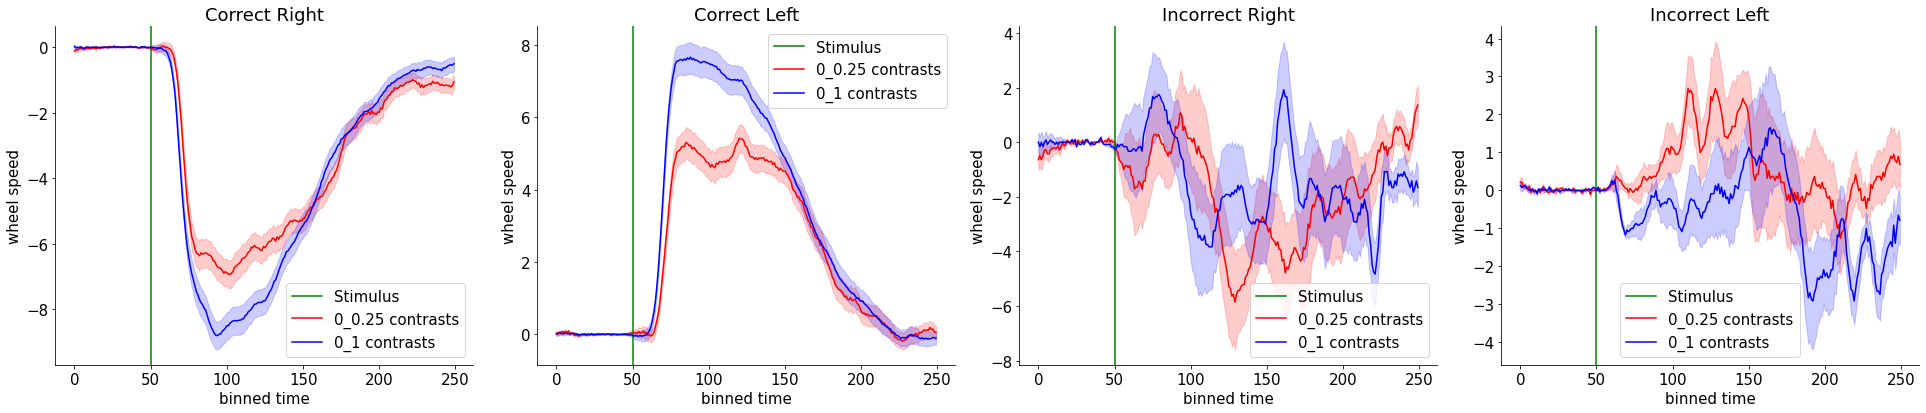

In [ ]:
#@title Plots
c = 1
x = np.arange(0, 250, 1)
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
plt.figure(figsize=(27,6))

for i1, r in enumerate(['Correct', 'Incorrect']):
  for i2, side in enumerate(['Right', 'Left']):
    all_mean_ext_vel = []
    ext_vel_err = []
    ax2 = plt.subplot(1,4,c)

    all_mean_ext_vel.append(con_ext_vel[i1,i2,0].mean(axis=0))
    all_mean_ext_vel.append(con_ext_vel[i1,i2,1].mean(axis=0))

    ext_vel_err.append(con_ext_vel[i1,i2,0].std(axis=0)/np.sqrt(con_ext_vel[i1,i2,0].shape[0]))
    ext_vel_err.append(con_ext_vel[i1,i2,0].std(axis=0)/np.sqrt(con_ext_vel[i1,i2,0].shape[0]))
    
    c += 1

    tmp1, = plt.plot(all_mean_ext_vel[0], 'r');
    tmp0 = plt.axvline(x=50,color='g')
    ax2.fill_between(x, all_mean_ext_vel[0]-ext_vel_err[0], all_mean_ext_vel[0]+ext_vel_err[0], alpha=0.2, color='r')
    ax2.fill_between(x, all_mean_ext_vel[1]-ext_vel_err[1], all_mean_ext_vel[1]+ext_vel_err[1], alpha=0.2, color='b')
    tmp2, = plt.plot(all_mean_ext_vel[1], 'b');

    ax2.set(xlabel='binned time', ylabel='wheel speed', title='{} {}'.format(r, side));
    ax2.legend((tmp0, tmp1, tmp2), ('Stimulus','0_0.25 contrasts', '0_1 contrasts'))

### Neural responses

In [ ]:
#@title Required data
Areas=["VISam","VISp","VPL","SUB","ACA","ILA","MOp","MOs","PL","ZI","CP","SNr","MRN"]
ext_spk = [[[[[[] for j4 in range(2)] for j3 in range(2)] for j2 in range(2)] for j1 in range(39)] for j0 in range(len(Areas))]

counter = 0
dic_area={}

for a, area in enumerate(Areas):
  dic_area[area]=a
  for i0, data in enumerate(alldat): 
    response = data['response']
    contrast_r = data['contrast_right']
    contrast_l = data['contrast_left']
    correct_idx = np.logical_or(np.logical_and(response>0, contrast_l-contrast_r>=0),
                                np.logical_and(response<0, contrast_l-contrast_r<=0))
    wrong_idx = np.logical_or(np.logical_and(response>0, contrast_l-contrast_r<=0),
                                np.logical_and(response<0, contrast_l-contrast_r>=0))
    
    right_idx = response<0
    left_idx = response>0

    ext_025_idx = np.logical_and(contrast_r*contrast_l==0, contrast_r+contrast_l==0.25)
    ext_01_idx = np.logical_and(contrast_r*contrast_l==0, contrast_r+contrast_l==1)

    ext_2525_idx = np.logical_and(contrast_r==0.25, contrast_l==0.25)
    ext_5050_idx = np.logical_and(contrast_r==0.50, contrast_l==0.50)
    ext_11_idx = np.logical_and(contrast_r==1, contrast_l==1)

    ext_255_idx = np.logical_and(contrast_r*contrast_l==0.125, contrast_r+contrast_l==0.75)
    ext_251_idx = np.logical_and(contrast_r*contrast_l==0.25, contrast_r+contrast_l==1.25)

    NN = len(data['brain_area']) 
    barea = 0 * np.ones(NN, ) 
    barea[np.isin(data['brain_area'], [area])] = 1 
    selected_area=1

    for i1, r in enumerate([correct_idx, wrong_idx]):
      for i2, side in enumerate([right_idx, left_idx]):
        for i3, diff in enumerate([ext_025_idx, ext_01_idx]):
          ext_spk[a][i0][i1][i2][i3] = data['spks'][barea==selected_area][:,np.logical_and(np.logical_and(r,side),diff)]
          if False:
            print(ext_spk[a][i0][i1][i2][i3].shape)
            counter += 1

ext_spk = np.array(ext_spk)

count=0
ext_re = [[[[[[] for j4 in range(2)] for j3 in range(2)] for j2 in range(2)] for j1 in range(39)] for j0 in range(len(Areas))]
for area in Areas:
  for se in range(39):
    for r in [0,1]:
      for side in [0,1]:
        for diff in [0,1]:
          ext_re[dic_area[area]][se][r][side][diff]=np.reshape(ext_spk[dic_area[area]][se][r][side][diff],(-1,250))
ext_re=np.array(ext_re)  

ext_a = [[[[[] for j4 in range(2)] for j3 in range(2)] for j2 in range(2)] for j0 in range(len(Areas))]

for area in Areas:
  for r in [0,1]:
    for side in [0,1]:
      for diff in [0,1]:
        curr_arr=np.ones((1,250))
        for se in range(39):
          if ext_re[dic_area[area]][se][r][side][diff].shape[0]!=0:
            curr_arr=np.concatenate((curr_arr, ext_re[dic_area[area]][se][r][side][diff]), axis=0)
        ext_a[dic_area[area]][r][side][diff]=curr_arr[1:,:]

ext_a=np.array(ext_a)

In [ ]:
#@title Required functions
def my_choice(min_NO,*args):
  ans=[]
  for item in args:
    ans.append(item[np.random.choice(item.shape[0], min_NO, replace=False)])
  return ans


def concatenate(*args):
  ans=np.ones((1,250))
  for item in args:
    ans=np.concatenate((ans,item),axis=0)
  ans=ans[1:,:]
  return ans


def mean_err(signals):
  if signals.shape[0]!=0:
    err = signals.std(axis=0)/np.sqrt(signals.shape[0])
    m=signals.mean(axis=0)
  else:
    m=err=np.array([0 for i in range(signals.shape[1])])
  return m,err


def myplot(plt,x,red,red_err,blue,blue_err,title,legend_tuple,xlabel='binned time (10ms)',ylabel='firing rate'):
  plt.plot(red, 'r');
  plt.fill_between(x, red-red_err, red+red_err, alpha=0.2, color='r')
  plt.plot(blue, 'b');
  plt.fill_between(x, blue-blue_err, blue+blue_err, alpha=0.2, color='b')
  plt.axvline(x=50,color='g')
  plt.set_title(title)
  plt.set(xlabel=xlabel, ylabel=ylabel);
  plt.legend(legend_tuple)


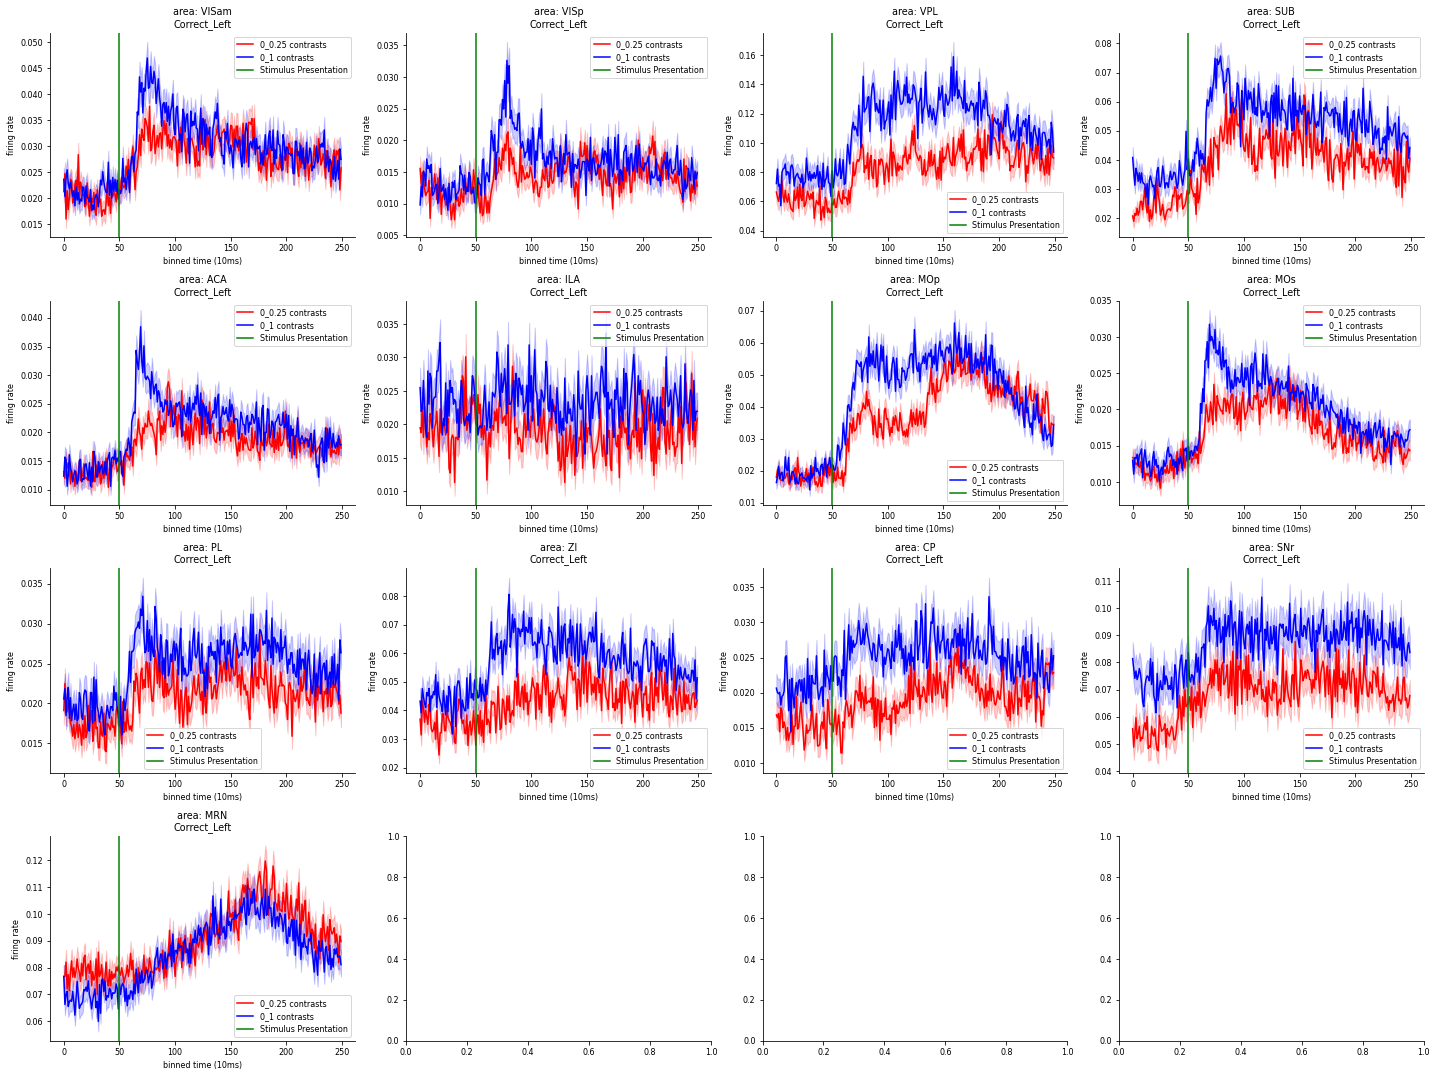

In [ ]:
#@title Plots
x = np.arange(0, 250, 1)
rcParams['figure.figsize'] = [20, 15]
rcParams['font.size'] =8
fig, ax = plt.subplots(4,4)

for a,area in enumerate(Areas):
  
  correct_right_025 = ext_a[dic_area[area]][0][0][0]
  wrong_right_025 =   ext_a[dic_area[area]][1][0][0]
  correct_left_025 =  ext_a[dic_area[area]][0][1][0]
  wrong_left_025 =    ext_a[dic_area[area]][1][1][0]
  correct_right_1 =   ext_a[dic_area[area]][0][0][1]
  wrong_right_1 =     ext_a[dic_area[area]][1][0][1]
  correct_left_1 =    ext_a[dic_area[area]][0][1][1]
  wrong_left_1 =      ext_a[dic_area[area]][1][1][1]
  
  c1=a//4
  c2=a%4
  
  min_NO_025=min(len(correct_right_025),len(correct_left_025))
  min_NO_1=min(len(correct_right_1),len(correct_left_1))

  min1_25 = min(len(correct_left_025), len(correct_left_1))

  ch_correct_right_025, ch_correct_left_025=my_choice(min_NO_025, correct_right_025, correct_left_025)
  ch_correct_right_1, ch_correct_left_1=my_choice(min_NO_1, correct_right_1, correct_left_1)

  ch_correct_left_025, ch_correct_left_1 = my_choice(min1_25, correct_left_025, correct_left_1)

  # s025=concatenate(ch_correct_right_025, ch_correct_left_025)
  s025=concatenate(ch_correct_left_025)
  # s1=concatenate(ch_correct_right_1, ch_correct_left_1)
  s1=concatenate(ch_correct_left_1)

  s025, s025_err=mean_err(s025)
  s1,s1_err=mean_err(s1)

  legend=("0_0.25 contrasts","0_1 contrasts","Stimulus Presentation")
  myplot(ax[c1][c2],x,s025,s025_err,s1,s1_err,"area: "+area+"\nCorrect_Left",legend)
